<a href="https://colab.research.google.com/github/nmaketh/mlops_pest_classifier/blob/main/mlops_pest_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports and Global Setup

In [1]:
# notebooks/01_image_model_training_evaluation.ipynb

print("--- Cell 1: Imports and Global Setup ---")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2 # For Transfer Learning
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
import json
import os

# NEW: Import kagglehub
import kagglehub

# Ensure these sklearn metrics are imported here at the very top
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# Define image dimensions and batch size
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# Define paths for model saving and class labels (DATA_DIR will be set by Kaggle download)
MODEL_SAVE_PATH = '../src/model/pest_classifier.h5'
CLASS_LABELS_PATH = '../src/model/class_labels.json'

print("Imports and Global Setup Complete.")

--- Cell 1: Imports and Global Setup ---
Imports and Global Setup Complete.


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vencerlanz09/agricultural-pests-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 102M/102M [00:00<00:00, 150MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vencerlanz09/agricultural-pests-image-dataset/versions/1


Load and Prepare the Dataset

In [3]:
# notebooks/01_image_model_training_evaluation.ipynb

print("\n--- Cell 2: Downloading, Loading, and Preparing the Dataset (Debugging) ---")

# Download dataset using kagglehub
print("Downloading dataset from Kaggle...")
download_path = kagglehub.dataset_download("vencerlanz09/agricultural-pests-image-dataset")
print(f"Dataset downloaded to: {download_path}")

# --- NEW DEBUGGING STEP ---
print(f"Listing contents of the downloaded path: {download_path}")
try:
    downloaded_contents = os.listdir(download_path)
    print("Contents:", downloaded_contents)
    if not downloaded_contents:
        print("Warning: Downloaded path appears empty. This might indicate an issue with the download or an archive that needs further extraction.")
except Exception as e:
    print(f"Error listing contents: {e}")
# --- END NEW DEBUGGING STEP ---


# IMPORTANT: The actual images might be in a subfolder within the downloaded path.
# We're commenting out the direct assumption for now, until we know the correct subfolder.
# DATA_DIR = os.path.join(download_path, 'pests') # OLD - commented out for debugging

# You will need to manually adjust DATA_DIR based on the 'Contents:' output above.
# For example, if 'Contents:' shows ['another_folder', 'images_here'], you might set:
# DATA_DIR = os.path.join(download_path, 'images_here')
# For now, let's keep it pointing to the root of the download_path and see its contents.
DATA_DIR = download_path # Temporarily set DATA_DIR to the root download path for initial inspection


print(f"Attempting to load images from (initial check): {DATA_DIR}")

# Create training and validation datasets
# This part might still fail if images are in a subfolder, but the 'Contents:' output is key.
try:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE
    )

    # Get class names
    class_names = train_ds.class_names
    print(f"Found {len(class_names)} classes: {class_names}")

    # Configure dataset for performance
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    print("Dataset Loading and Preparation Complete.")

except Exception as e:
    print(f"Error loading dataset from {DATA_DIR}: {e}")
    print("Please inspect the 'Contents:' output above and manually set DATA_DIR to the correct subfolder if necessary.")


--- Cell 2: Downloading, Loading, and Preparing the Dataset (Debugging) ---
Dataset downloaded to: /root/.cache/kagglehub/datasets/vencerlanz09/agricultural-pests-image-dataset/versions/1
Listing contents of the downloaded path: /root/.cache/kagglehub/datasets/vencerlanz09/agricultural-pests-image-dataset/versions/1
Contents: ['beetle', 'ants', 'snail', 'earwig', 'grasshopper', 'wasp', 'earthworms', 'slug', 'bees', 'moth', 'weevil', 'catterpillar']
Attempting to load images from (initial check): /root/.cache/kagglehub/datasets/vencerlanz09/agricultural-pests-image-dataset/versions/1
Found 5494 files belonging to 12 classes.
Using 4396 files for training.
Found 5494 files belonging to 12 classes.
Using 1098 files for validation.
Found 12 classes: ['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']
Dataset Loading and Preparation Complete.


Save Class Names

In [4]:
# notebooks/01_image_model_training_evaluation.ipynb

print("\n--- Cell 3: Saving Class Names ---")
os.makedirs(os.path.dirname(CLASS_LABELS_PATH), exist_ok=True)
with open(CLASS_LABELS_PATH, 'w') as f:
    json.dump(class_names, f)
print(f"Class names saved to {CLASS_LABELS_PATH}")


--- Cell 3: Saving Class Names ---
Class names saved to ../src/model/class_labels.json


Define Data Augmentation Layer

In [5]:
# notebooks/01_image_model_training_evaluation.ipynb

print("\n--- Cell 4: Defining Data Augmentation Layer ---")

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(IMG_HEIGHT,
                                   IMG_WIDTH,
                                   3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
  ],
  name="data_augmentation",
)

print("Data Augmentation Layer Defined.")


--- Cell 4: Defining Data Augmentation Layer ---
Data Augmentation Layer Defined.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 Load and Freeze MobileNetV2 Base Model

In [6]:
# notebooks/01_image_model_training_evaluation.ipynb

print("\n--- Cell 5: Loading and Freezing MobileNetV2 Base Model ---")

base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False

print("MobileNetV2 Base Model Loaded and Frozen.")


--- Cell 5: Loading and Freezing MobileNetV2 Base Model ---


/tmp/ipython-input-6-2018286145.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV2 Base Model Loaded and Frozen.


Build Custom Classification Head

In [7]:
# notebooks/01_image_model_training_evaluation.ipynb

print("\n--- Cell 6: Building Custom Classification Head ---")

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
num_classes = len(class_names)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

print("Custom Classification Head Built.")


--- Cell 6: Building Custom Classification Head ---
Custom Classification Head Built.


Compile Model (Phase 1: Top Layers Training)

In [8]:
# notebooks/01_image_model_training_evaluation.ipynb

print("\n--- Cell 7: Compiling Model (Phase 1: Top Layers Training) ---")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()
print("Model Compiled for Phase 1 Training.")


--- Cell 7: Compiling Model (Phase 1: Top Layers Training) ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,004 (9.88 MB)

 Trainable params: 331,020 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Model Compiled for Phase 1 Training.


Train Model (Phase 1: Top Layers Training)

In [9]:
# notebooks/01_image_model_training_evaluation.ipynb

print("\n--- Cell 8: Training Model (Phase 1: Training only the top layers) ---")
early_stopping_callback_phase1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_phase1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping_callback_phase1]
)

print("Phase 1 Training Complete.")


--- Cell 8: Training Model (Phase 1: Training only the top layers) ---
Epoch 1/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.1394 - loss: 3.4261 - val_accuracy: 0.5656 - val_loss: 1.5004
Epoch 2/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.3492 - loss: 2.0554 - val_accuracy: 0.6667 - val_loss: 1.1918
Epoch 3/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.4773 - loss: 1.6391 - val_accuracy: 0.7031 - val_loss: 1.0264
Epoch 4/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5128 - loss: 1.4794 - val_accuracy: 0.7304 - val_loss: 0.9381
Epoch 5/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5567 - loss: 1.3514 - val_accuracy: 0.7459 - val_loss: 0.8634
Epoch 6/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.5906 - loss: 1.2833 - val_accuracy: 0.7550 - val_loss: 0.8195
Epoch 7/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6210 - loss: 1.1891 - val_accuracy: 0.7559 - val_loss: 0.7922
Epoch 8/30
138/138 ━━━

Setup for Fine-tuning (Phase 2)

In [10]:
# notebooks/01_image_model_training_evaluation.ipynb

print("\n--- Cell 9: Setting Up for Fine-tuning (Phase 2) ---")

base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()
print("Fine-tuning Setup Complete. Model Recompiled.")


--- Cell 9: Setting Up for Fine-tuning (Phase 2) ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,004 (9.88 MB)

 Trainable params: 1,857,420 (7.09 MB)

 Non-trainable params: 731,584 (2.79 MB)

Fine-tuning Setup Complete. Model Recompiled.


Fine-tune Model (Phase 2)

In [11]:
# notebooks/01_image_model_training_evaluation.ipynb

print("\n--- Cell 10: Fine-tuning Model (Phase 2) ---")

early_stopping_callback_finetune = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    initial_epoch=history_phase1.epoch[-1] if history_phase1.epoch else 0,
    callbacks=[early_stopping_callback_finetune]
)

combined_history = {}
for key in history_phase1.history.keys():
    combined_history[key] = history_phase1.history[key] + history_finetune.history[key]

print("Phase 2 Fine-tuning Complete.")


--- Cell 10: Fine-tuning Model (Phase 2) ---
Epoch 30/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.5584 - loss: 1.3614 - val_accuracy: 0.7778 - val_loss: 0.6698
Epoch 31/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.6539 - loss: 1.0448 - val_accuracy: 0.7750 - val_loss: 0.6913
Epoch 32/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6855 - loss: 0.9530 - val_accuracy: 0.7778 - val_loss: 0.6952
Epoch 33/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6986 - loss: 0.8971 - val_accuracy: 0.7796 - val_loss: 0.6951
Epoch 34/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.7191 - loss: 0.8229 - val_accuracy: 0.7832 - val_loss: 0.6834
Epoch 35/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.7200 - loss: 0.8380 - val_accuracy: 0.7851 - val_loss: 0.6788
Epoch 36/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.7250 - loss: 0.8042 - val_accuracy: 0.7887 - val_loss: 0.6651
Epoch 37/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 1

Evaluate Model and Plot History


--- Cell 11: Evaluating Model and Plotting History ---
Validation Loss: 0.5604
Validation Accuracy: 0.8233

--- Detailed Evaluation Metrics ---
F1 Score (weighted): 0.8175
Precision Score (weighted): 0.8232
Recall Score (weighted): 0.8233

--- Classification Report ---
              precision    recall  f1-score   support

        ants       0.89      0.89      0.89        95
        bees       0.73      0.93      0.82        88
      beetle       0.75      0.57      0.64        67
catterpillar       0.77      0.68      0.72        90
  earthworms       0.76      0.80      0.78        75
      earwig       0.80      0.64      0.71       105
 grasshopper       0.68      0.77      0.72        90
        moth       0.92      0.99      0.95       101
        slug       0.85      0.57      0.68        81
       snail       0.93      1.00      0.96       103
        wasp       0.85      0.93      0.89        94
      weevil       0.88      0.97      0.93       109

    accuracy             

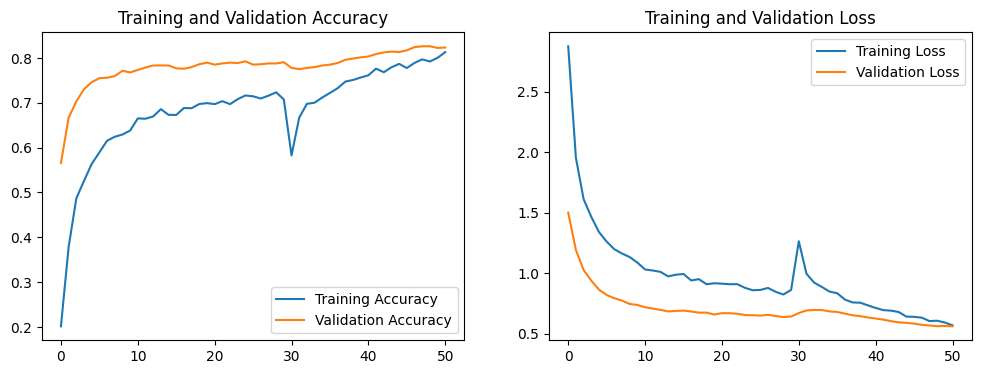

Model Evaluation and Plotting Complete.


In [12]:
# notebooks/01_image_model_training_evaluation.ipynb

print("\n--- Cell 11: Evaluating Model and Plotting History ---")

val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

true_labels = []
predicted_labels = []

for images, labels in val_ds:
    predictions = model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(predicted_classes)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

print("\n--- Detailed Evaluation Metrics ---")
print(f"F1 Score (weighted): {f1_score(true_labels, predicted_labels, average='weighted'):.4f}")
print(f"Precision Score (weighted): {precision_score(true_labels, predicted_labels, average='weighted'):.4f}")
print(f"Recall Score (weighted): {recall_score(true_labels, predicted_labels, average='weighted'):.4f}")

print("\n--- Classification Report ---")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

print("\n--- Plotting Training History ---")
acc = combined_history['accuracy']
val_acc = combined_history['val_accuracy']
loss = combined_history['loss']
val_loss = combined_history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print("Model Evaluation and Plotting Complete.")

Save the Trained Model

In [14]:
# notebooks/01_image_model_training_evaluation.ipynb

# Change the model save path to use the recommended .keras format
MODEL_SAVE_PATH = '../src/model/pest_classifier.keras'

print(f"\n--- Cell 12: Saving Model to {MODEL_SAVE_PATH} ---")
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
model.save(MODEL_SAVE_PATH)
print("Model saved successfully.")

print("\n--- Full Model Training and Evaluation Notebook Complete ---")
print("Once this runs successfully, we can proceed to Phase 3: Prediction API and UI Development, as per your MLOps assignment rubric.")


--- Cell 12: Saving Model to ../src/model/pest_classifier.keras ---
Model saved successfully.

--- Full Model Training and Evaluation Notebook Complete ---
Once this runs successfully, we can proceed to Phase 3: Prediction API and UI Development, as per your MLOps assignment rubric.
